In [15]:
import numpy as np
import numba as nb
import scipy as sp
import time
import matplotlib.pyplot as plt
from tqdm import trange



N = [60, 120, 240, 480, 960]
dt_arr = [0.1, 0.01, 0.01, 0.001, 0.0008]
t_m = 600
D0, D1 = 1.0, 10**(-2)
p0, p1 = 100, 100
teta0, teta1 = 43, 77
L = 60

#источники
def q0_source(t):
  return p0 * (np.sin(t * 2 * np.pi / teta0) + 1)
def q1_source(t):
  return p1 * (np.sin(t * 2 * np.pi / teta1) + 1)


In [16]:


@nb.jit(nopython=True, parallel = True)
def diffuse(
    it: int,
    Ni: int,
    T: np.ndarray,
    dx: float,
    dt: float,
    D: float,
):
  """
шаг диффузии. принимает данные по массиву - размер и консатнты.
делает шаг для всего массива
  """
    # it = 0: T[0] -> T[1]
  # it = 1: T[1] -> T[0]
  prev = int(it % 2)
  #cur  = (it + 1) % 2
  cur  = prev - 1
  for i in nb.prange(1, Ni - 1):
    for j in range(1, Ni - 1):
      tmp = dt * D[i, j] / dx**2
      T[cur, i, j] = T[prev, i, j] + tmp * (
        T[prev, i - 1, j] +
        T[prev, i + 1, j] +
        T[prev, i, j - 1] +
        T[prev, i, j + 1] -
        4 * T[prev, i, j])


def heat_source(T, arr, coord, q, dt, it):
  """
  тепло источников
  принимает данные об источниках и матрицу темпартур
  обновляет матрицу теплератур на координатах источников
  """
  T[(it % 2), arr[0] - coord[0]:arr[0] + coord[0],
    arr[1] - coord[1]:arr[1] + coord[1]] += q * dt



In [17]:
for i in range(len(N)):
  dt = dt_arr[i]
  dx = L / N[i]
  iterations = int(t_m / dt)
  ny = N[i]
  nx = N[i]
  #черные точки  находятся в координатах(40,40)(20,20)(20,40)(40, 20)
  black_dots = {0: (int(20 / dx), int(20 / dx)),
          1: (int(20 / dx), int(40 / dx)),
          2: (int(40 / dx), int(40/ dx)),
          3: (int(40/ dx), int(20/ dx))}

  T = np.zeros((2, ny, nx))
  D = np.full((N[i], N[i]), D0)

  #задаю белые границы
  # заполняю массив D материалом D1 (стенками)
  left = int(10 /dx)
  right = int(50 / dx)
  width = int(5 / dx)

  for k in range (right- width, right): # вехняя часть
    for m in range (left, right):
      D[k][m] = D1
  for k in range (left, right ): # правая часть
    for m in range (right - width, right):
      D[k][m] = D1
  for k in range (left, left + width): # нижняя часть
    for m in range (left, left + int(left*1.5)):
      D[k][m] = D1
    for m in range (right - int(left*1.5), right ):
      D[k][m] = D1
  for k in range (left, int(left*2.5)): # левая часть
    for m in range (left, left+width):
      D[k][m] = D1
  for k in range (right - int(left*1.5), right):
    for m in range (left, left+width):
      D[k][m] = D1



  #граничные условия, границы и прилегающие равны
  T[:, 0, :] = T[:, 1, :]
  T[:, -1, :] = T[:, -2, :]
  T[:, :, 0] = T[:, :, 1]
  T[:, :, -1] = T[:, :, -2]

  for j in range (nx):
    for k in range (2):
      T[k][0][j] = 0.0
      T[k][-1][j] = float(L)
  for j in range (ny):
    for k in range (2):
      T[k][j][0] = float(L)
      T[k][j][-1] = 0.0




  dots = np.zeros((4, iterations))
  ar = np.array([30 / dx, 60/8 / dx], dtype=int)
  param = np.array([10 / dx, 60/24/ dx], dtype=int)
  ar1 =  ar[::-1]
  param1 = param[::-1]
  import time # проверка времени отрисовки карты
  start = time.time() ## точка отсчета времени
  #добавим значения источников
  for it in trange (iterations):
    q0 = q0_source(dt * it)
    q1 =q1_source(dt * it)
    heat_source(T, ar, param, q0, dt, it)
    heat_source(T, ar1,param1, q1, dt, it)
    diffuse(it, N[i], T, dx, dt, D)
    #print(N[i])
    for key, (x, y) in black_dots.items():
        dots[key, int(it)] = T[int((it + 1) % 2), x, y]

  end = time.time() - start ##  время работы программы
  print(end)
  np.save(f'T_file_{N[i]}.npy', T)
  np.save(f't1{N[i]}.npy', dots)
  np.save(f'cord{N[i]}.npy', np.array([list(p) for p in black_dots.values()]))
  np.save(f'Diff_{N[i]}.npy', D)





100%|██████████| 6000/6000 [00:01<00:00, 5520.98it/s]


1.1000919342041016


100%|██████████| 60000/60000 [00:06<00:00, 9672.45it/s]


6.221649885177612


100%|██████████| 60000/60000 [00:22<00:00, 2648.95it/s]


22.674214363098145


100%|██████████| 600000/600000 [05:06<00:00, 1960.64it/s]


306.03676676750183


100%|██████████| 750000/750000 [24:48<00:00, 503.91it/s]


1488.3615274429321


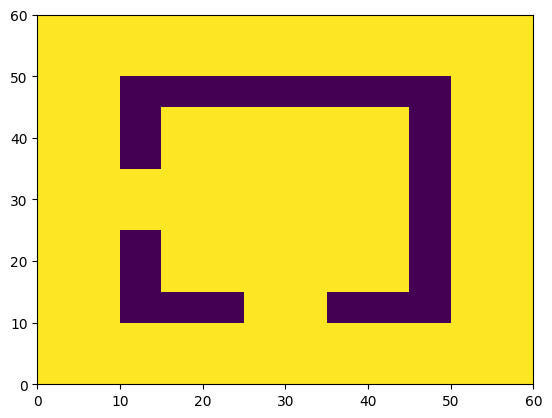

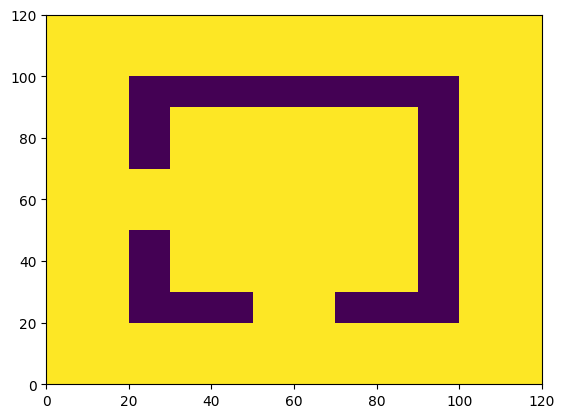

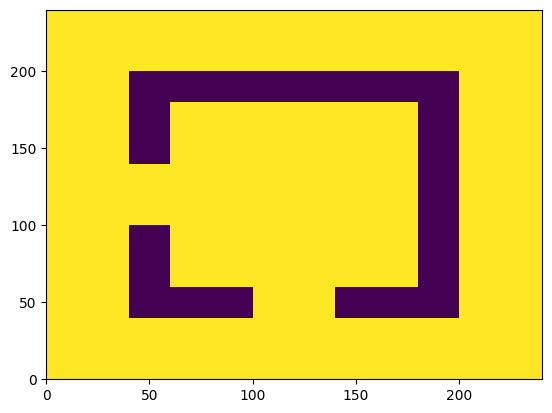

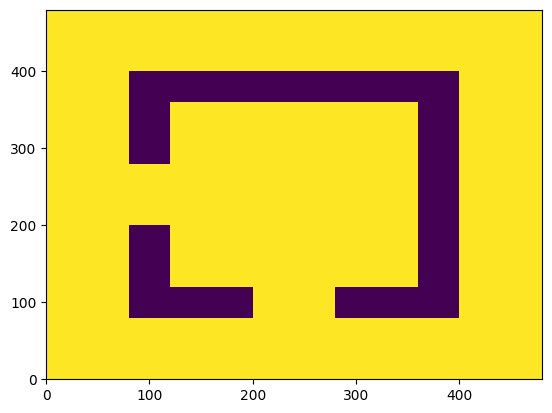

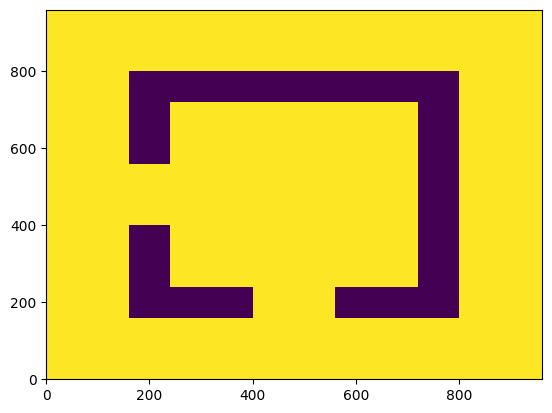

In [18]:
#отрисовка модели
for n in N:
  plt.figure()
  D = np.load(f'Diff_{n}.npy')
  pic = plt.pcolormesh(D)

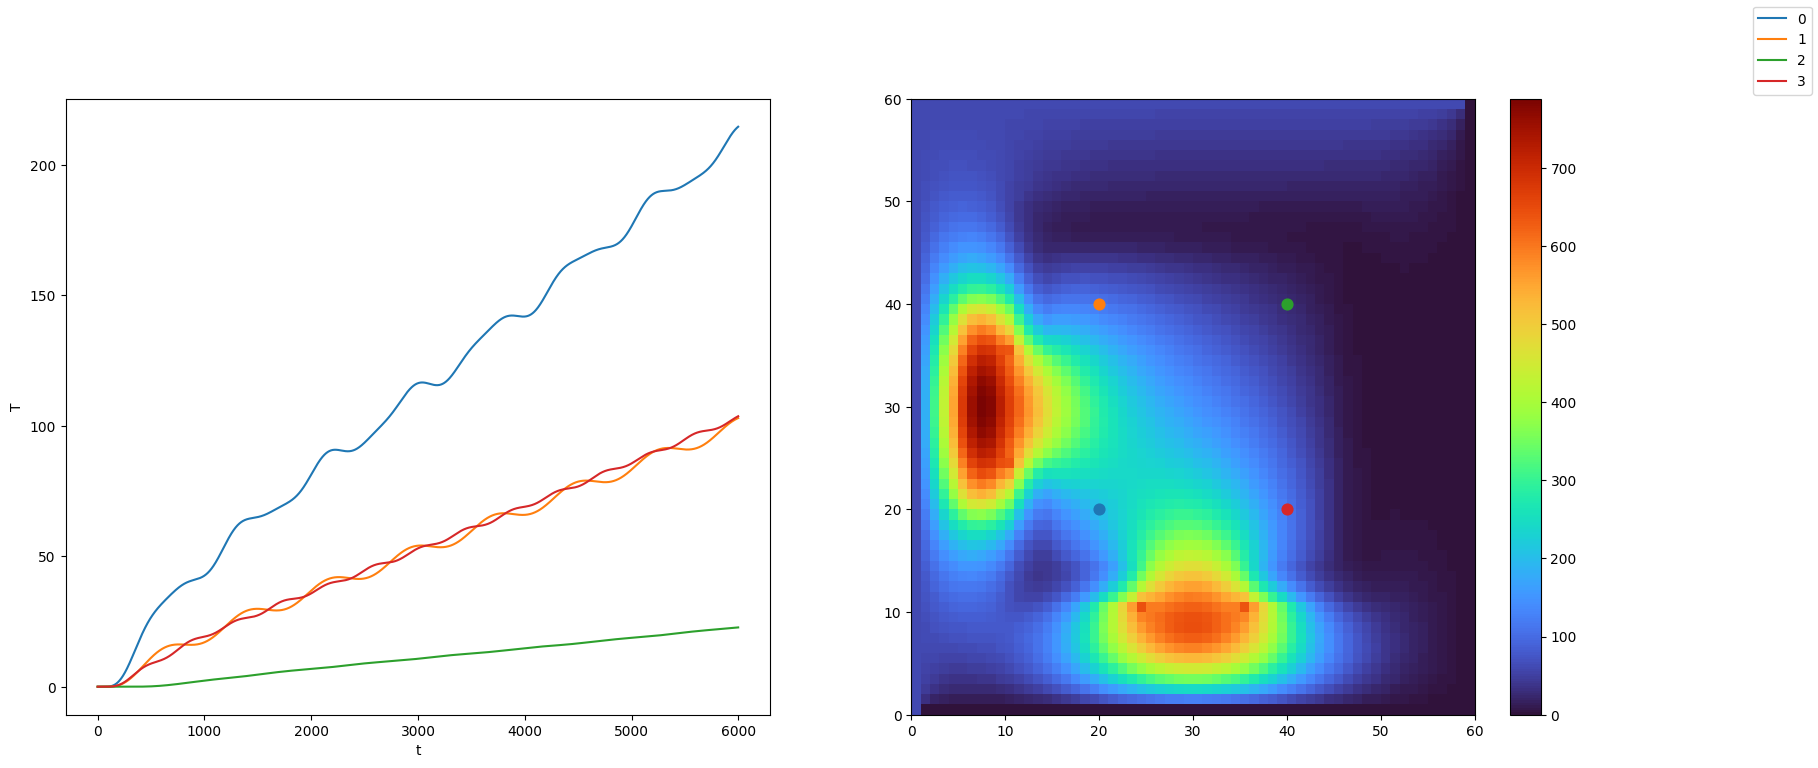

для точки  0 :
[0.00775968 0.00096996]
для точки  1 :
[0.00141687 0.00017711]
для точки  2 :
[9.16640336e-14]
для точки  3 :
[0.00146308]


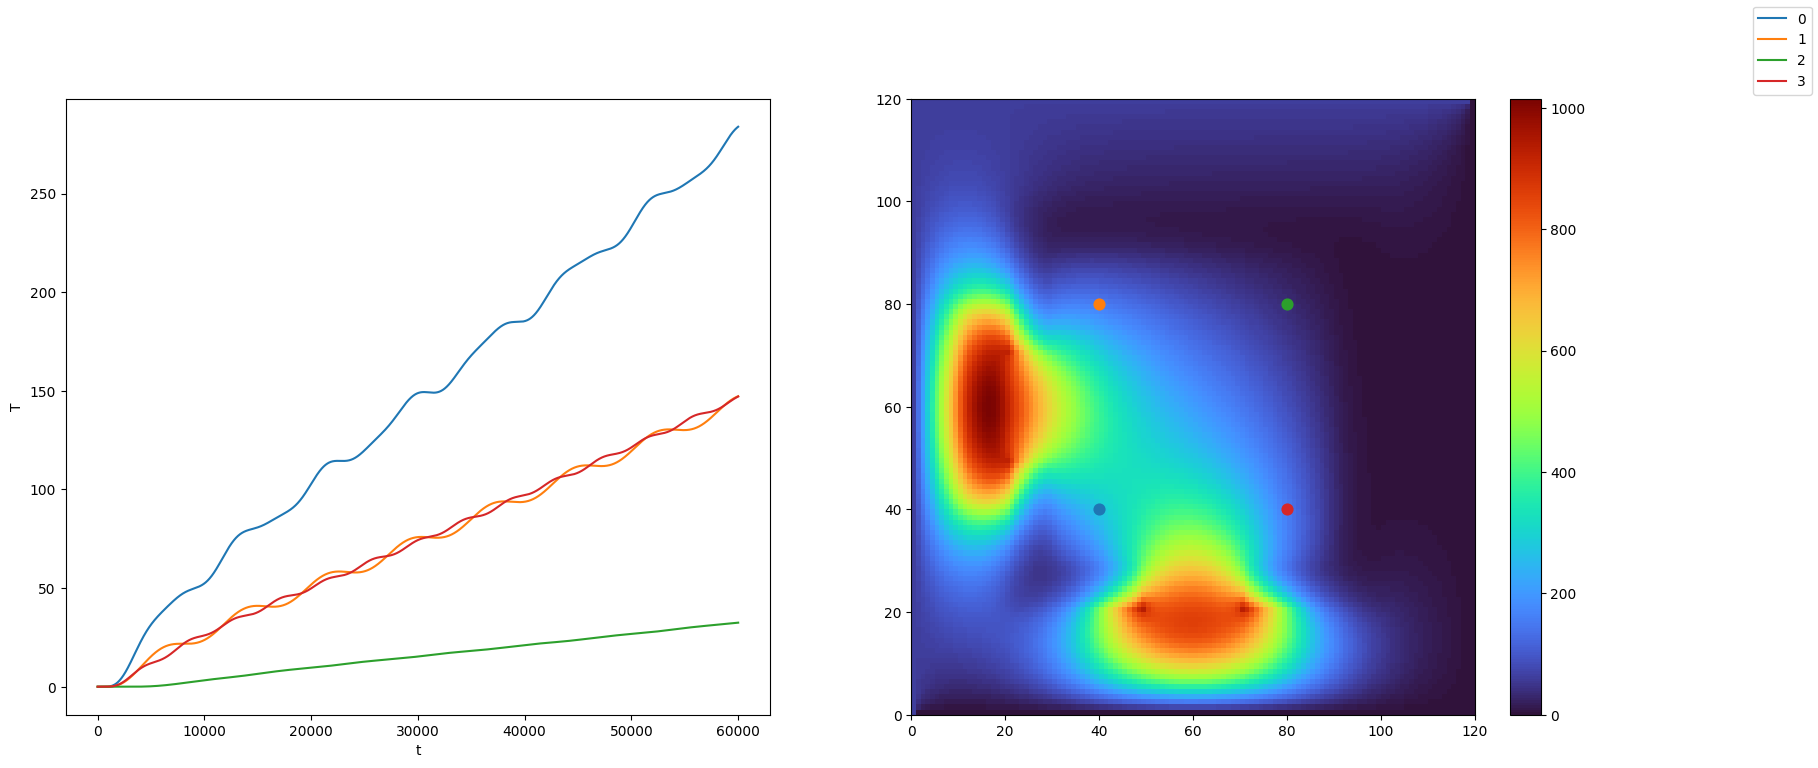

для точки  0 :
[1.14472348e-12 1.43090435e-13]
для точки  1 :
[1.19406811e-13 1.49258513e-14]
для точки  2 :
[3.71270093e-42]
для точки  3 :
[1.19733911e-13]


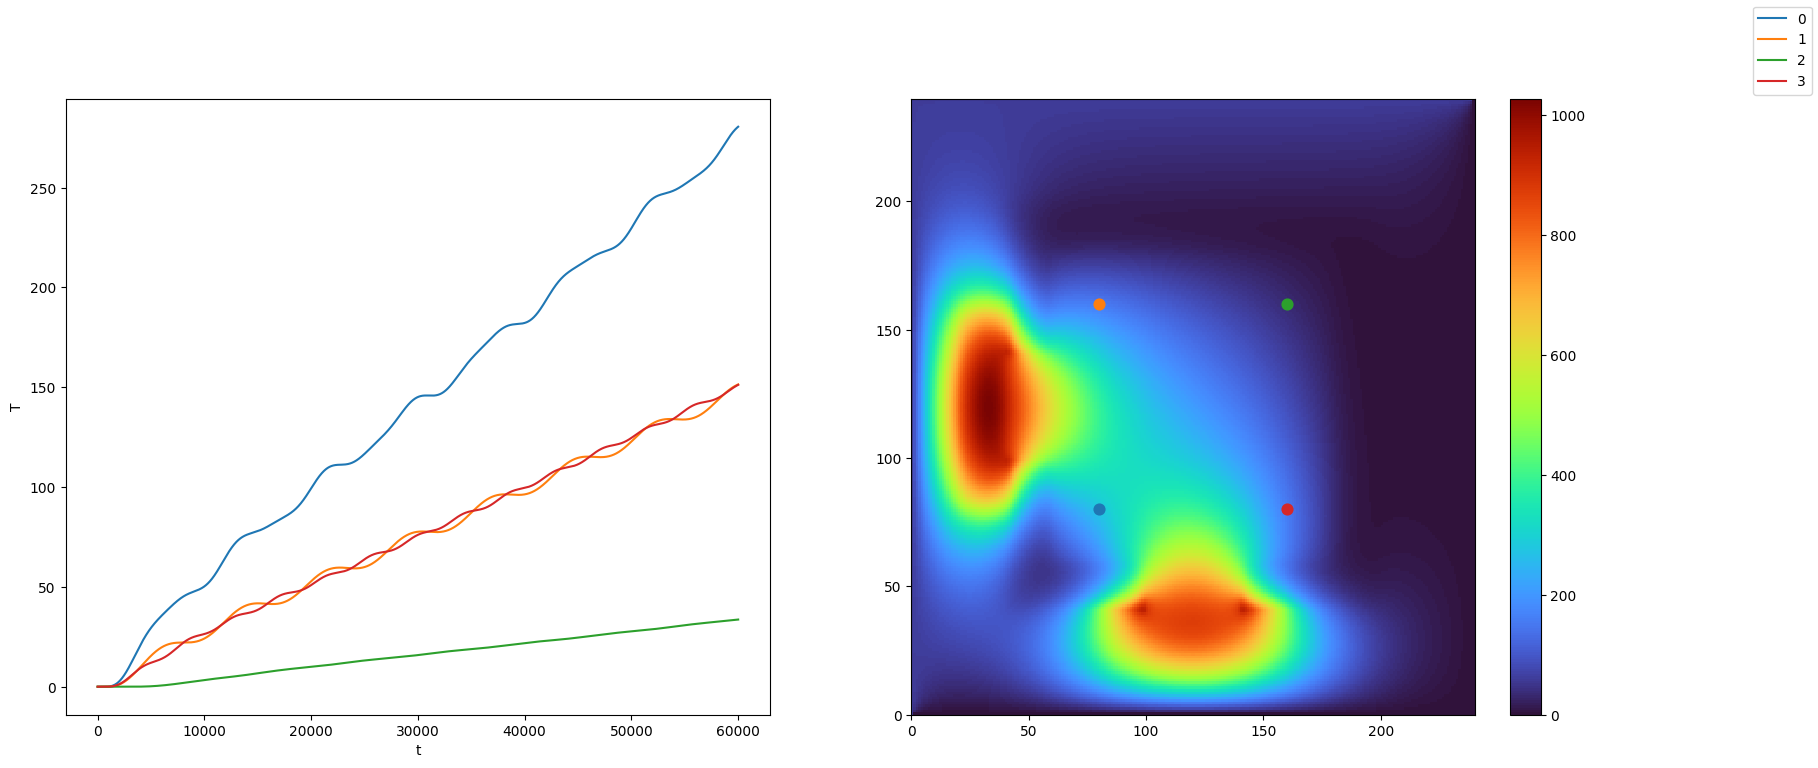

для точки  0 :
[2.36202118e-07 2.95252648e-08]
для точки  1 :
[6.9127128e-08 8.6408910e-09]
для точки  2 :
[3.99990305e-44]
для точки  3 :
[6.96636029e-08]


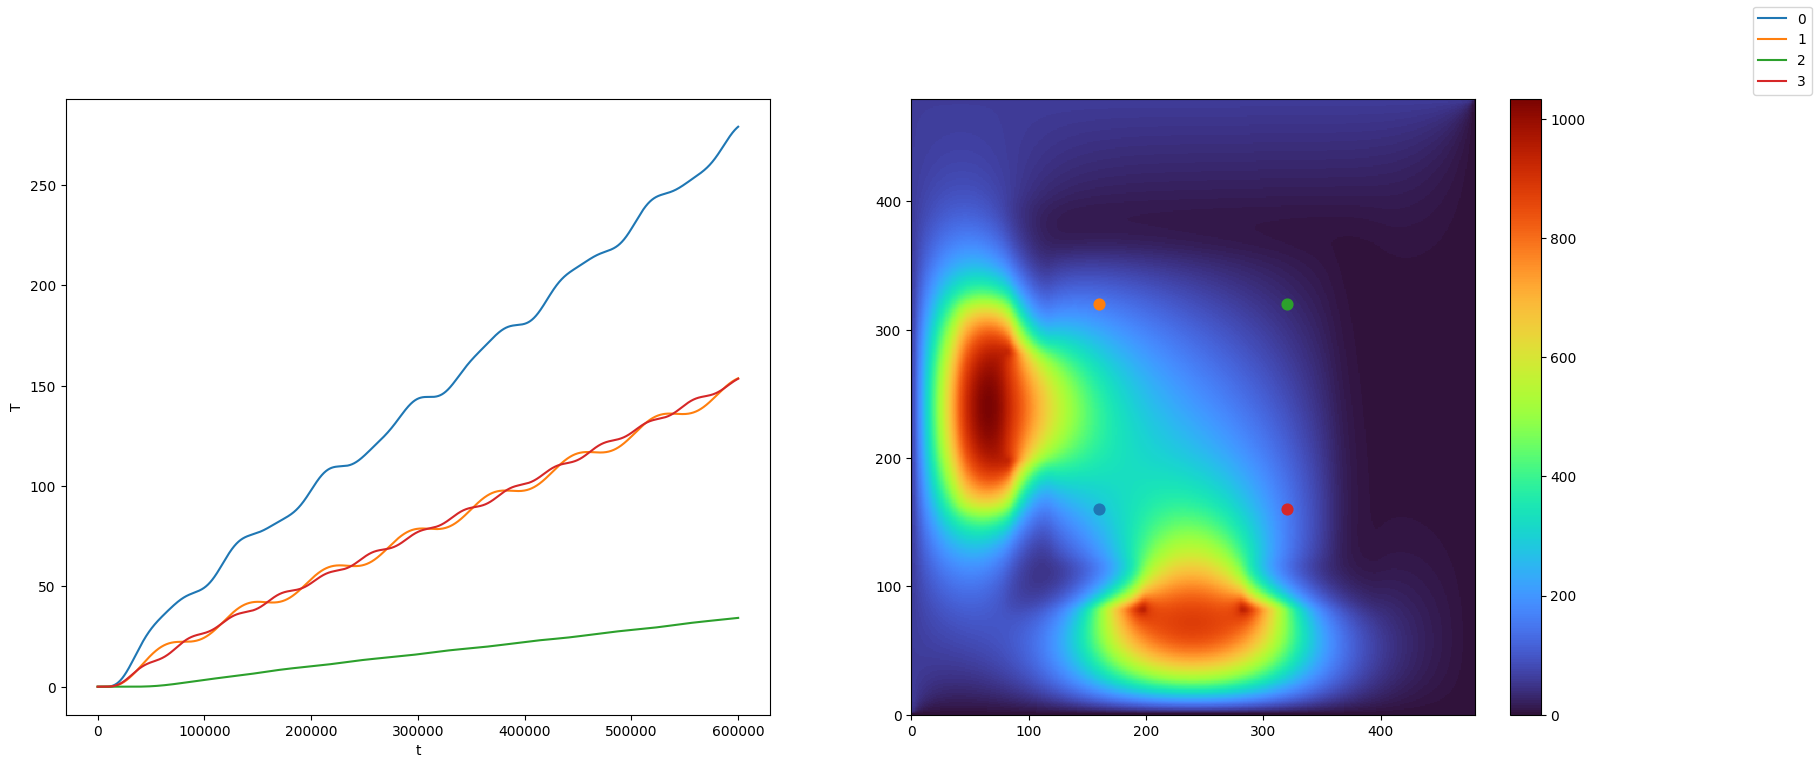

для точки  0 :
[1.33009653e-33 1.66262067e-34]
для точки  1 :
[2.28101750e-34 2.85127188e-35]
для точки  2 :
[2.92385543e-148]
для точки  3 :
[2.28194767e-34]


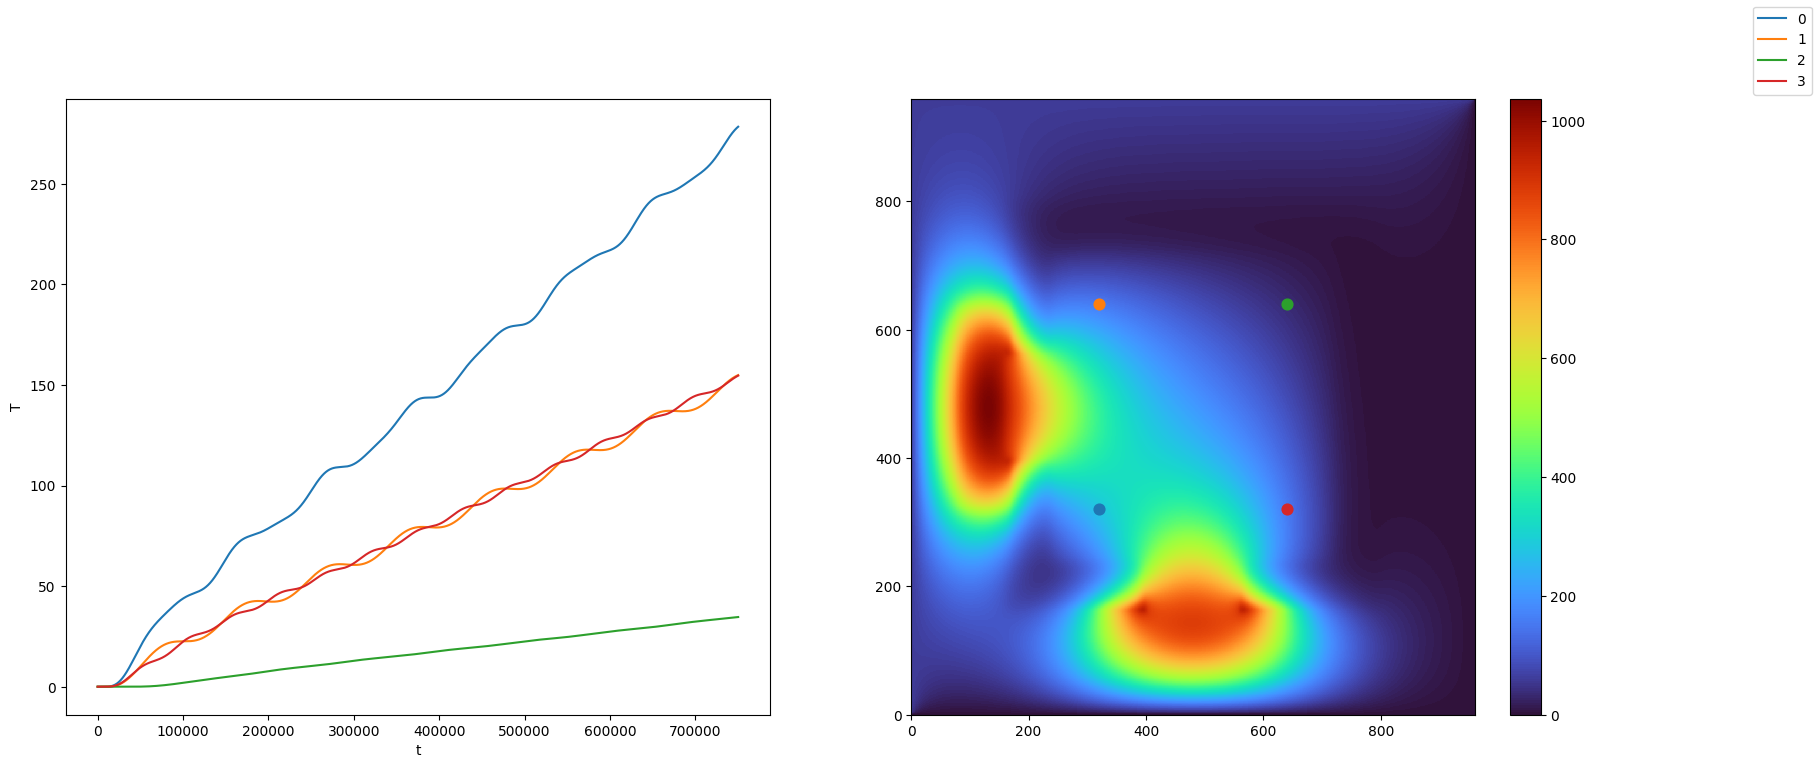

для точки  0 :
[1.02603105e-22 1.28253882e-23]
для точки  1 :
[3.51087375e-23 4.38859218e-24]
для точки  2 :
[1.12623714e-139]
для точки  3 :
[3.51408853e-23]


In [19]:
from scipy.signal import find_peaks

"""
отрисовка графиков для всех N
данные получает из файлов, сохраненных ранее
"""

for n in N:
  dotss = np.load(f't1{n}.npy')
  xandy = np.load(f'cord{n}.npy')
  T = np.load(f'T_file_{n}.npy')

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
  for num in range(4):
    ax1.plot(dotss[num], label=num)
  ax1.set_xlabel('t')
  ax1.set_ylabel('T')

  pic = plt.pcolormesh(T[0], cmap='turbo')
  for num in range(4):
    ax2.scatter(*xandy[num], label=num, s=60)
  fig.legend(labels=np.arange(4))
  fig.colorbar(pic)
  plt.show()

  """
  точки 4, считаем период
  счет периодов через Фурье
  """

  for i in range (4):
    print("для точки ", i, ":")
    signal = dotss[i, :]
    signal_fft = np.fft.rfft(signal - signal.mean())
    #print("sig: ", signal_fft)
    amplitude = (np.abs(signal_fft) / (n / 2))
    dt = abs(dotss[i, n-1]- dotss[i, n-2])
    rfftfreq_ = np.fft.rfftfreq(n, dt)
    peaks_idx, _ = find_peaks(amplitude)
    #print("peaks_idx: ", peaks_idx)
    print((1 / rfftfreq_[peaks_idx]))


# Новый раздел